In [1]:
import numpy as np
import matplotlib.pyplot as plt


from uncertainties import ufloat
import uncertainties.unumpy as unp

from scipy.optimize import curve_fit
import scipy.odr as odr

In [27]:
laserSpotHeight = [155, 157]
platformHeightFromGround = [108, 107]
containerHeight = [3.3, 3.6]

heights = [(h1 - (h2 + h3))/100 for h1, h2, h3 in zip(laserSpotHeight, platformHeightFromGround, containerHeight)]
print(f"Height measurements: {heights}")

H = ufloat(np.mean(heights), np.std(heights)) # meters
L = 5.59 # meters

lightWavelength = 633e-9 # m
waterDensity = 998.2 # kg m^-3
soapDensity = waterDensity

grazingAngle = unp.arctan2(H, L)

rootPath = "/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/"

Height measurements: [0.43700000000000006, 0.4640000000000001]


In [3]:
def LoadData(path):
    data = np.loadtxt(path, skiprows=1)

    frequencies = data[:,0]
    spacings = data[:,1]/1000 # change mm to m
    spacingUncertanties = data[:,2]/1000

    spacings = np.array([ufloat(spacing, uncertainty) for spacing, uncertainty in zip(spacings, spacingUncertanties)])

    return (frequencies, spacings)

In [4]:
def GetAngularFrequencies(frequencies):
    angularFrequencies = 2 * np.pi * frequencies
    return angularFrequencies

In [5]:
def GetDiffractionAngles(spacings):
    # Input in meters will give an output in degrees

    diffractionAngles = unp.arctan2(spacings, L)

    return diffractionAngles

In [6]:
def GetWaveNumbers(diffractionAngles):
    innerBracket = unp.sin(grazingAngle + diffractionAngles / 2) + unp.sin(grazingAngle - diffractionAngles / 2)

    waveNumbers = 2 * (np.pi / lightWavelength) * unp.sin(diffractionAngles / 2) * innerBracket

    return waveNumbers

In [8]:
def LinearFunc(p, x):
    m, c = p
    return m * x + c

def PerformODR(function, x, y, xErr):
    model = odr.Model(function)

    data = odr.Data(x, y, wd= 1/xErr)

    odrOutput = odr.ODR(data, model, beta0=[0.03, 0])

    return odrOutput.run()

In [7]:
# De-ionised water @ room temperature

waterFrequencies, waterSpacings = LoadData(rootPath + "/water.txt")

waterAngularFrequencies = GetAngularFrequencies(waterFrequencies)

waterDiffractionAngles = GetDiffractionAngles(waterSpacings)

waterWaveNumbers = GetWaveNumbers(waterDiffractionAngles)


Beta: [0.04682018 0.        ]
Beta Std Error: [0.00213984 0.        ]
Beta Covariance: [[1.26825251e-15 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 3610427349.0068936
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


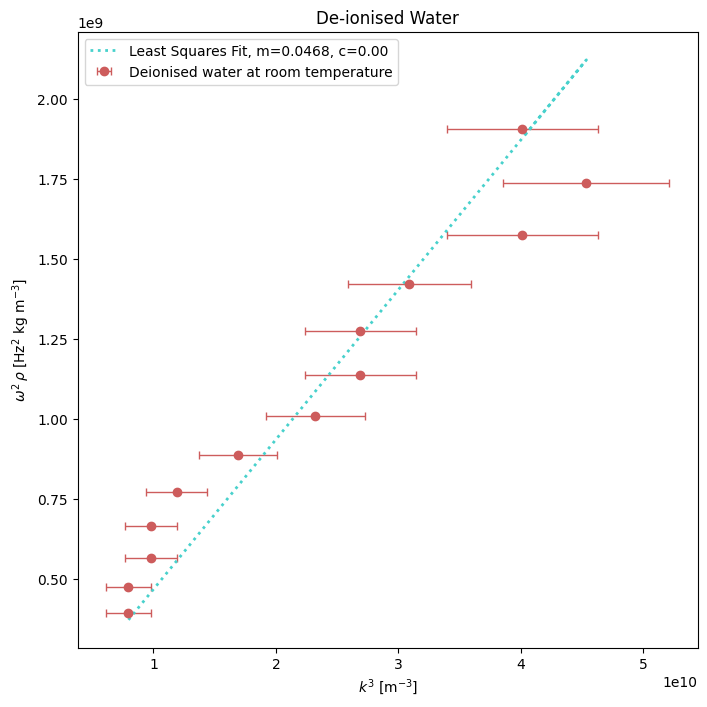

In [22]:
waterXValues = unp.nominal_values(waterWaveNumbers**3)
waterXErr = unp.std_devs(waterWaveNumbers**3)

waterYValues = unp.nominal_values(waterDensity * waterAngularFrequencies**2)
waterYErr = unp.std_devs(waterDensity * waterAngularFrequencies**2)

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(waterXValues, waterYValues, xerr=waterXErr, fmt="o", color="indianred", capsize=3, linewidth=1, label="Deionised water at room temperature")


regression = PerformODR(LinearFunc, waterXValues, waterYValues, waterXErr)
#waterPars, waterCov = curve_fit(LinearFunc, waterXValues, waterYValues, [0.03, 0])

regression.pprint()

waterXRange = np.linspace(np.min(waterXValues), np.max(waterXValues), 10)
ax.plot(waterXValues, LinearFunc(regression.beta, waterXValues), color="mediumturquoise", lw=2, ls="dotted", label=f"Least Squares Fit, m={regression.beta[0]:.4f}, c={regression.beta[1]:.2f}")
#ax.plot(waterXValues, LinearFunc(waterXValues, waterPars[0], waterPars[1]), color="indianred", ls="dashed", label="Least Squares Fit")

ax.set_xlabel("$k^3$ [m$^{-3}$]")
ax.set_ylabel(r"$\omega^2 \,\rho$ [Hz$^2$ kg m$^{-3}$]")
ax.legend()
ax.set_title("De-ionised Water");

# Soap

In [25]:
# 250 ml de-ionised water, 50 ml concentrated soap stirred well @ room temperature

soapFrequencies, soapSpacings = LoadData(rootPath + "/soap.txt")

soapAngularFrequencies = GetAngularFrequencies(soapFrequencies)

soapDiffractionAngles = GetDiffractionAngles(soapSpacings)

soapWaveNumbers = GetWaveNumbers(soapDiffractionAngles)


Beta: [0.02392908 0.        ]
Beta Std Error: [0.00220689 0.        ]
Beta Covariance: [[8.26961871e-16 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
Residual Variance: 5889468559.802946
Inverse Condition #: 0.9999999999999999
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


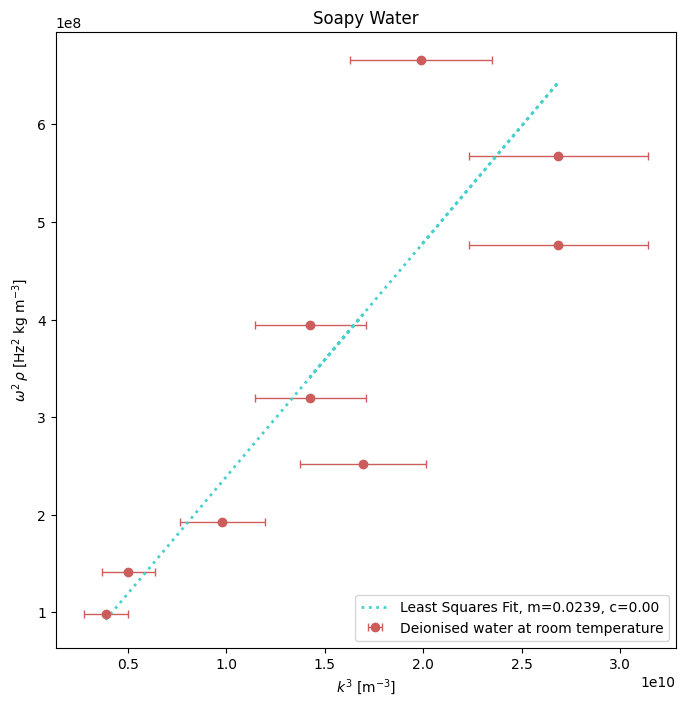

In [29]:
soapXValues = unp.nominal_values(soapWaveNumbers**3)
soapXErr = unp.std_devs(soapWaveNumbers**3)

soapYValues = unp.nominal_values(soapDensity * soapAngularFrequencies**2)
soapYErr = unp.std_devs(soapDensity * soapAngularFrequencies**2)

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(soapXValues, soapYValues, xerr=soapXErr, fmt="o", color="indianred", capsize=3, linewidth=1, label="Deionised water at room temperature")


regression = PerformODR(LinearFunc, soapXValues, soapYValues, soapXErr)
#waterPars, waterCov = curve_fit(LinearFunc, waterXValues, waterYValues, [0.03, 0])

regression.pprint()

soapXRange = np.linspace(np.min(soapXValues), np.max(soapXValues), 10)
ax.plot(soapXValues, LinearFunc(regression.beta, soapXValues), color="mediumturquoise", lw=2, ls="dotted", label=f"Least Squares Fit, m={regression.beta[0]:.4f}, c={regression.beta[1]:.2f}")
#ax.plot(waterXValues, LinearFunc(waterXValues, waterPars[0], waterPars[1]), color="indianred", ls="dashed", label="Least Squares Fit")

ax.set_xlabel("$k^3$ [m$^{-3}$]")
ax.set_ylabel(r"$\omega^2 \,\rho$ [Hz$^2$ kg m$^{-3}$]")
ax.legend()
ax.set_title("Soapy Water");